## Clip Vertical Displacement Geotiff

#### Needed: Single merged geotiff from alaska satellite facility (see Merge_ASF_Scenes code). Due to the time it takes to run code, it  helps to manually clip the broad area in arcgis or a similar program.

#### Result: Clipped vertical displacement raster with exact same dimensions as vegetation (and hopefully soon JABLTCX) data. This will probably need further reprojecting but the spatial extent and shape should be identical.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep
import rasterio as rio
import rioxarray as rxr
from shapely.geometry import box
import scipy.stats as stats
import skimage.transform as st
from osgeo import gdal

/Users/tylerlogie/opt/anaconda3/envs/geostats_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# most important thing is that the vegetation and vertical displacement data are correlated. once volume change is
# properly integrated we can run a similar reprojection for that

# first, import the two files that are being reprojected together
vert_disp = rxr.open_rasterio(
    "../RawData/partial_clipped_10_08_to_11_25_combined.tiff",
    masked=True
)
veg_before = rxr.open_rasterio(
    "../../Vegetation/RawData/NDVI image Before.tif",
    masked=True
)
veg_after = rxr.open_rasterio(
    "../../Vegetation/RawData/NDVI image After.tif",
    masked=True
)

veg = veg_after - veg_before

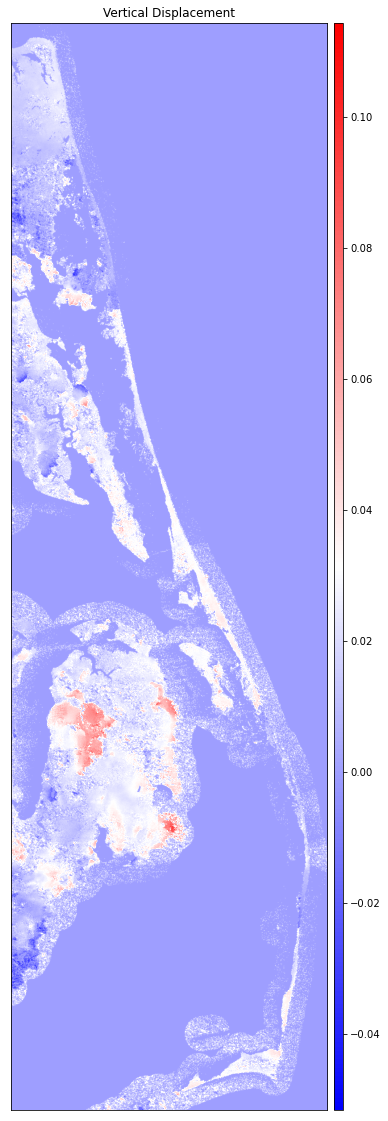

<AxesSubplot:title={'center':'Vertical Displacement'}>

In [3]:
ep.plot_bands(vert_disp, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

In [4]:
print(vert_disp.rio.resolution())
print(veg_after.rio.resolution())

(30.0, -30.0)
(8.983152841195215e-05, -8.983152841195215e-05)


In [5]:
upscale_factor = 0.1
print(veg.rio.width)
new_width = round(veg.rio.width * upscale_factor)
new_height = round(veg.rio.height * upscale_factor)
print(new_height)
veg_change_downsampled = veg.rio.reproject(
    veg.rio.crs,
    shape=(new_height, new_width),
    resampling=rio.enums.Resampling.bilinear,
)
veg_after_downsampled = veg_after.rio.reproject(
    veg_after.rio.crs,
    shape=(new_height, new_width),
    resampling=rio.enums.Resampling.bilinear,
)
veg_before_downsampled = veg_before.rio.reproject(
    veg_before.rio.crs,
    shape=(new_height, new_width),
    resampling=rio.enums.Resampling.bilinear,
)
print(veg_change_downsampled.rio.resolution())

6947
1986
(0.00089792752212637, -0.0008983152841195151)


In [7]:
print(veg_change_downsampled)

<xarray.DataArray (band: 1, y: 1986, x: 695)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.10157569, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.08182283, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -76.06 -76.06 -76.05 ... -75.44 -75.43 -75.43
  * y            (y) float64 36.96 36.96 36.95 36.95 ... 35.18 35.17 35.17 35.17
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38


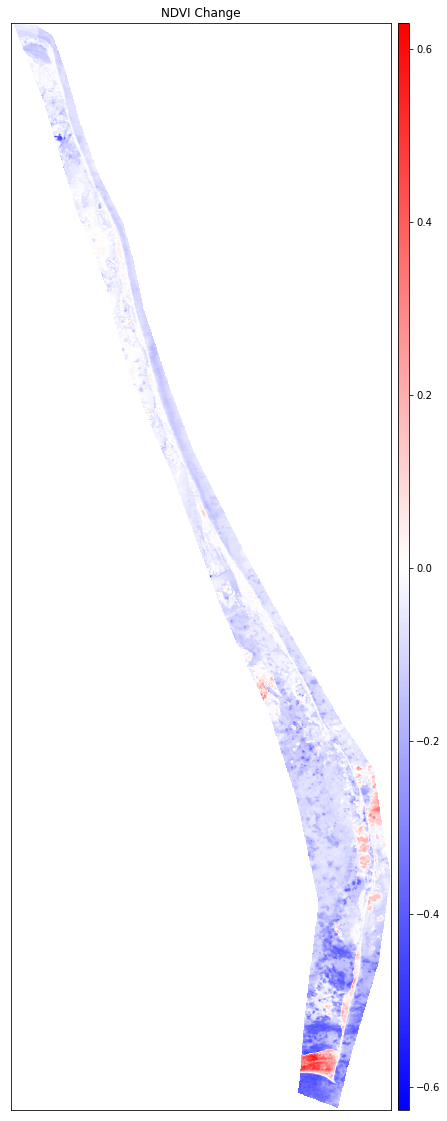

In [8]:
ep.plot_bands(veg_change_downsampled,
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

In [14]:
# the crs are likely different for data from different sites. using reproject_match we can get them into the same scheme
print("Original Vertical Displacement CRS:", vert_disp.rio.crs)
print("Vegetation CRS:", veg_change_downsampled.rio.crs)

vert_disp_new = vert_disp.rio.reproject_match(veg_change_downsampled)
# the new vertical displacement crs should match the vegetation crs. if not, something has gone wrong.
# note: this can take a second
print("Reprojected Vegetation Displacement CRS:", veg_change_downsampled.rio.crs)

Original Vertical Displacement CRS: EPSG:32618
Vegetation CRS: EPSG:4326
Reprojected Vegetation Displacement CRS: EPSG:4326


In [15]:
# manually input the coordinates of outer banks kml file. this will be used to form a polygon to clip the vertical
# displacement raster.
geoms = [{'type': 'Polygon', 'coordinates': [[(-75.5649, 35.4359),(-75.5774, 35.3337),(-75.5889, 35.1984),
                                              (-75.52, 35.1725),(-75.5023, 35.2456),(-75.4524, 35.414),
                                              (-75.433, 35.5557),(-75.4615, 35.7352),(-75.5146, 35.8125),
                                              (-75.5959, 35.9524),(-75.6708, 36.0845),(-75.7566, 36.2564),
                                              (-75.7946, 36.3574),(-75.837, 36.4861),(-75.8554, 36.5716),
                                              (-75.8714, 36.6285),(-75.8855, 36.6576),(-75.9126, 36.7112),
                                              (-75.9443, 36.8002),(-75.9537, 36.8366),(-75.9686, 36.8867),
                                              (-75.9868, 36.9362),(-76.0129, 36.9526),(-76.057, 36.9565),
                                              (-76.006, 36.825),(-75.9527, 36.648),(-75.904, 36.5225),
                                              (-75.8666, 36.3768),(-75.7944, 36.2111),(-75.7309, 36.0382),
                                              (-75.5649, 35.4359)]]}]
# clip the data using above polygon
clipped = vert_disp_new.rio.clip(geoms)

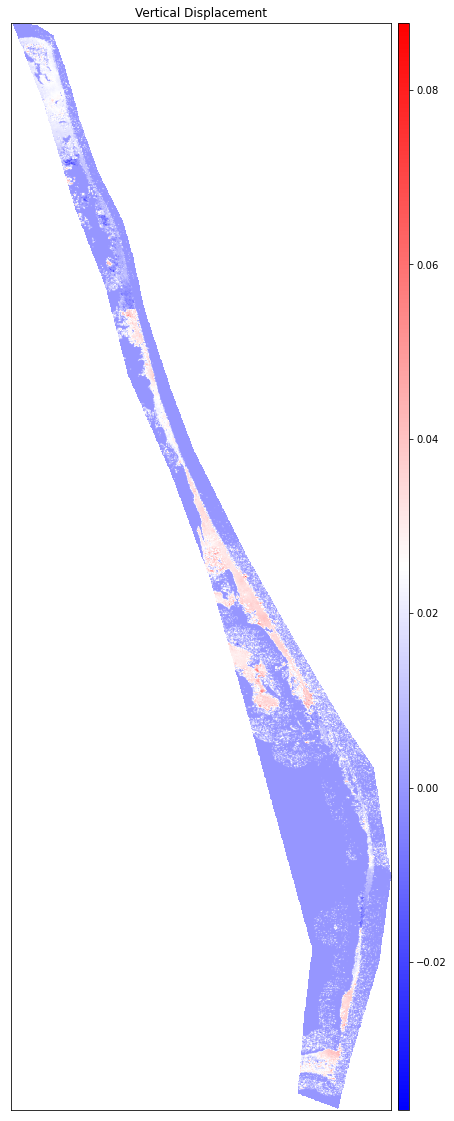

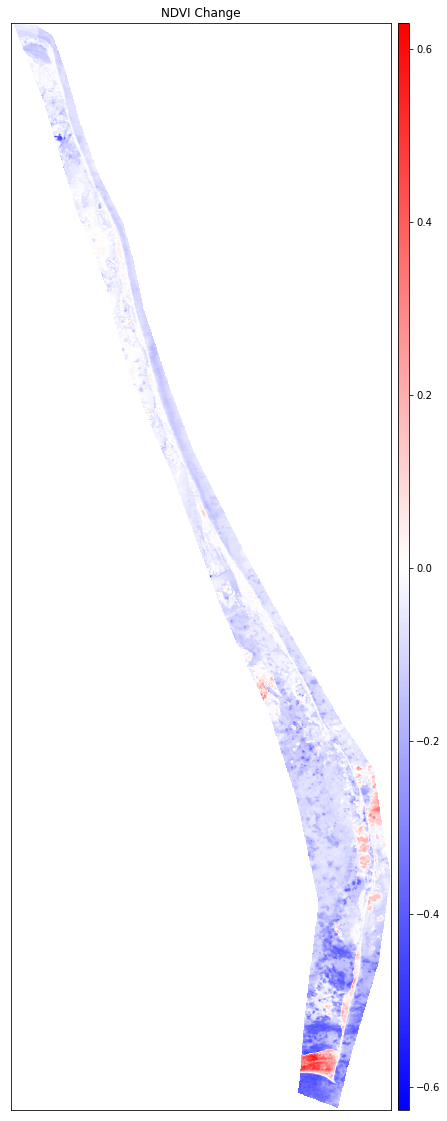

In [16]:
# the area of this plot should look like the area of the vegetation raster
# this can take quite a while, especially with geotiffs that aren't already cut down some
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,30))
ep.plot_bands(clipped, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

ep.plot_bands(veg_change_downsampled,
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

In [17]:
print(type(clipped))
print(type(veg))
print(clipped)
print(veg)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<xarray.DataArray (band: 1, y: 1986, x: 695)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 36.96 36.96 36.95 36.95 ... 35.18 35.17 35.17 35.17
  * x            (x) float64 -76.06 -76.06 -76.05 ... -75.44 -75.43 -75.43
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
<xarray.DataArray (band: 1, y: 19860, x: 6947)>
array([[[0.05845633, 0.08341625, 0.11157522, ...,        nan,
                nan,        nan],
        [0.09978211, 0.08369619, 0.07976189, ...,        nan,
                nan,        nan],

### Downsampling
These datasets are extremely large at the scale that was given by reproject_match. Next task is to downsample the data to a 80x80 m resolution

In [18]:
# now export the created clipped geotiff
# the metadata is already saved to the geotiff
# double check that the resolutions are the same
#clipped.rio.resolution = (80,80)
#veg.rio.resolution = (80,80)
"""upscale_factor = 
new_width = xds.rio.width * upscale_factor
new_height = xds.rio.height * upscale_factor

xds_upsampled = xds.rio.reproject(
    xds.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)
print(clipped.rio.resolution())
print(veg.rio.resolution())
print(os.getcwd())"""

veg_before_downsampled.rio.to_raster("../../Vegetation/RawData/veg_before_2018_downsampled.tif", driver="GTiff")
veg_after_downsampled.rio.to_raster("../../Vegetation/RawData/veg_after_2018_downsampled.tif", driver="GTiff")
veg_change_downsampled.rio.to_raster("../../Vegetation/RawData/veg_change_2018_downsampled.tif", driver="GTiff")
clipped.rio.to_raster("../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif", driver="GTiff")


#clipped_raster = clipped.rio.to_raster("../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif")
# save file as geotiff
#out_file = "../ProcessedData/complete_clipped_2018_10_08_to_11_25_combined.tif"
# if there is already a file with this name, delete and resave the new file
#if os.path.isfile(out_file):
#    os.remove(out_file)
# write the geotiff file with relavent metadata using rio.open
#with rio.open(out_file, "w", driver=clipped.driver) as dest:
#        dest.write(clipped)

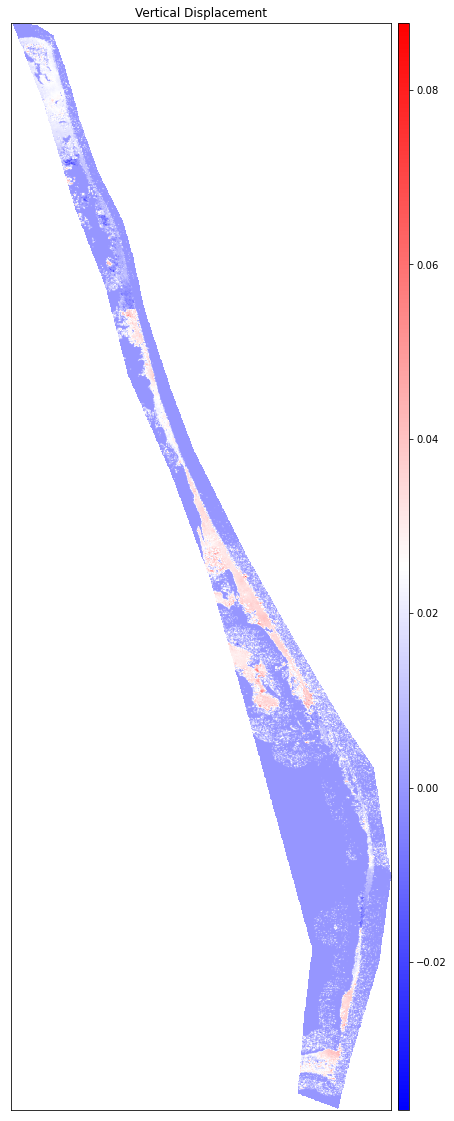

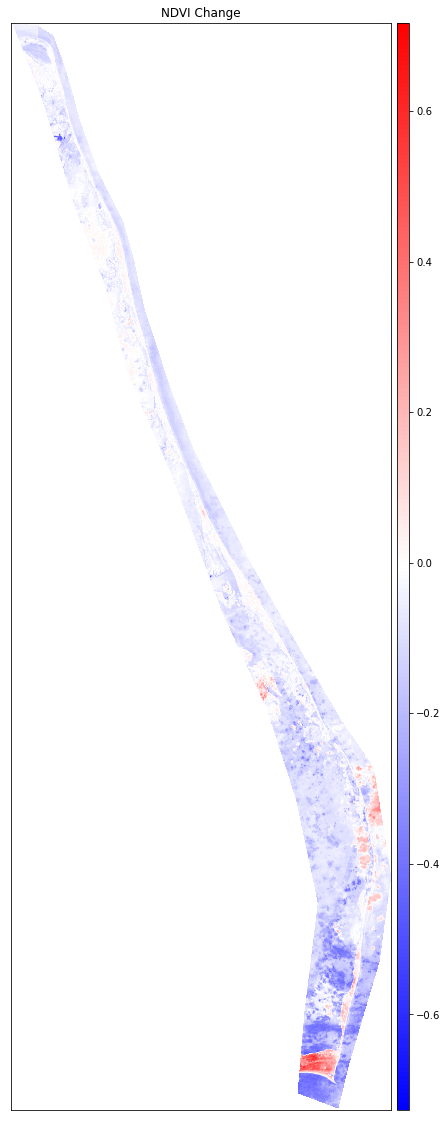

In [19]:
ep.plot_bands(clipped, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

ep.plot_bands(veg,
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

## Prepare to add to dataframe

Flatten the arrays, add them to a pandas dataframe, and drop any rows with nan values. This table is export as a csv, and will be used in a second file with the main model and analysis code.

In [20]:
# for whatever reason, the vertical displacement dataset has one extra pixel of height over the vegetation datasets.
# in order to get these the same size, we dropped the first row of the displacement data, which only had no non-nan values

clipped_2d = clipped[0]
print(clipped_2d.shape)
clipped_new = clipped_2d[1:][:]
print(clipped_new.shape)

(1986, 695)
(1985, 695)


In [21]:
# example linear regression comparing values from the clipped vertical displacement data and the vegetation data
# the [0] is because it creates a 3d array that is more difficult to model with, but the outermost shell of the array
# only has one value containing all data points in a 2d array.


X, Y1, Y2, Y3 = clipped_new.values,veg_before_downsampled.values[0][:-1],veg_after_downsampled.values[0][:-1],veg_change_downsampled.values[0][:-1]
print(type(X),type(Y1), type(Y2), type(Y3))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [22]:
flat_X = X.flatten().reshape(-1,1)
flat_Y1 = Y1.flatten().reshape(-1,1)
flat_Y2 = Y2.flatten().reshape(-1,1)
flat_Y3 = Y2.flatten().reshape(-1,1)
print(flat_X.shape, flat_Y1.shape, flat_Y2.shape, flat_Y3.shape)

(1379575, 1) (1379575, 1) (1379575, 1) (1379575, 1)


In [23]:
# this is a much faster way to do it than the code below, but we're having trouble figuring out how to get them the 
# same size before going through the necessary processing of nan values

twoD_array = np.concatenate([flat_X, flat_Y1, flat_Y2,flat_Y3], axis=1)
print(twoD_array.shape)
df = pd.DataFrame(twoD_array,columns= ['Vertical Displacement','NDVI Before','NDVI After', 'NDVI Change'])

# somehow NDVI change was reset to NDVI after
df['NDVI Change'] = df['NDVI After'] - df['NDVI Before']

# convert 0s to nan (remove water included in vertical displacement)

# drop all nans from df
df = df.dropna(axis = 0, how = 'any')
df.head()

(1379575, 4)


,Vertical Displacement,NDVI Before,NDVI After,NDVI Change
697,0.0,-0.396801,-0.295225,0.101576
698,0.0,-0.392374,-0.290362,0.102012
699,0.0,-0.383619,-0.310560,0.073059
1392,0.0,-0.386987,-0.305164,0.081823
1393,0.0,-0.388311,-0.313319,0.074992


In [24]:
ep.plot_bands(df["Vertical Displacement"], 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )

ep.plot_bands(df["NDVI Change"],
         title="NDVI Change",
         cmap = "bwr",
         figsize = (10,20)
        )
plt.show()

In [25]:
filepath = "../ProcessedData/Model_Ready_Data.csv"
df.to_csv(filepath)

In [26]:
# direct iterative piecewise comparison of points, no longer necessary but kept in case some part is needed
"""
xvals = []
yvals = []
start_time = time.time()

counter = 100
for i in range(len(X)):
    if i % 1000 == 0:
        print(i)
        print("--- %s seconds ---" % (time.time() - start_time))
    for j in range(len(X[0])):
        if ( (np.isnan((X[i][j])) or (X[i][j] == 0) ) or (np.isnan((Y[i][j])) or (Y[i][j] == 0)) ):
            continue
        else:
            xvals.append(X[i][j])
            yvals.append(Y[i][j])"""

'\nxvals = []\nyvals = []\nstart_time = time.time()\n\ncounter = 100\nfor i in range(len(X)):\n    if i % 1000 == 0:\n        print(i)\n        print("--- %s seconds ---" % (time.time() - start_time))\n    for j in range(len(X[0])):\n        if ( (np.isnan((X[i][j])) or (X[i][j] == 0) ) or (np.isnan((Y[i][j])) or (Y[i][j] == 0)) ):\n            continue\n        else:\n            xvals.append(X[i][j])\n            yvals.append(Y[i][j])'

In [27]:
# as a model example, use the ols model from the multicollinearity methods hw
from statsmodels.api import OLS

#standardize data to assist in interpretation of coefficients
x_array = (df["Vertical Displacement"] - np.mean(df["Vertical Displacement"], axis=0)) / np.std(df["Vertical Displacement"], axis=0)

#standardize data to assist in interpretation of coefficients
y_array = (df["NDVI Change"] - np.mean(df["Vertical Displacement"])) / np.std(df["NDVI Change"])

lm = OLS(y_array,x_array)
lm_results = OLS(y_array,x_array).fit().summary()

In [28]:
lm_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            NDVI Change   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              6628.
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                        0.00
Time:                        17:20:20   Log-Likelihood:                     -3.1037e+05
No. Observations:              186715   AIC:                                  6.207e+05
Df Residuals:                  186714   BIC:                                  6.208e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Vertical Displacement     0.2404      0.003     81.414      0.000       0.235       0.246
==============================================================================
Omnibus:                    20740.790   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201806.694
Skew:                           0.020   Prob(JB):                         0.00
Kurtosis:                       8.093   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# Train a linear regression model using stats.linregress
slope, intercept, r_value, _, _ = stats.linregress(df["Vertical Displacement"], df["NDVI Change"])

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

slope: 1.9635435643835082 
intercept: -0.09400430693358655 
r squared: 0.05775344532707788


Text(0, 0.5, 'NDVI Change')

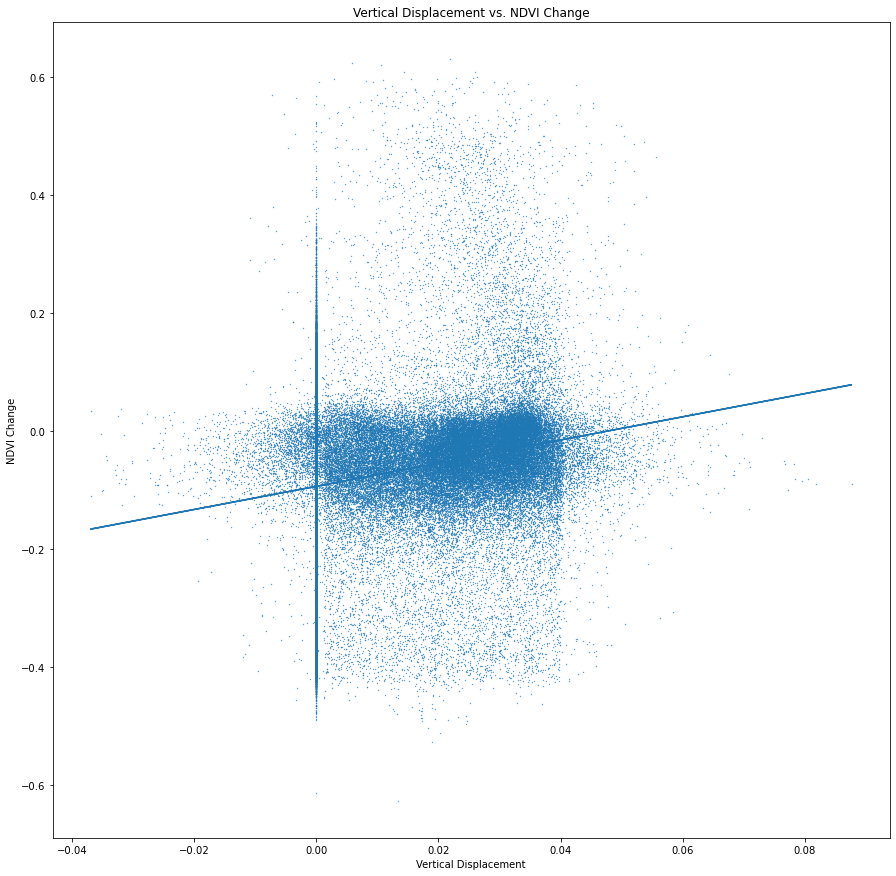

In [30]:
fig = plt.figure(figsize=(15,15))
plt.plot(df["Vertical Displacement"], np.multiply(slope,df["Vertical Displacement"])+intercept)
plt.scatter(df["Vertical Displacement"],df["NDVI Change"], s=0.1)
plt.title("Vertical Displacement vs. NDVI Change")
plt.xlabel("Vertical Displacement")
plt.ylabel("NDVI Change")

Text(0, 0.5, 'NDVI Before Hurricane')

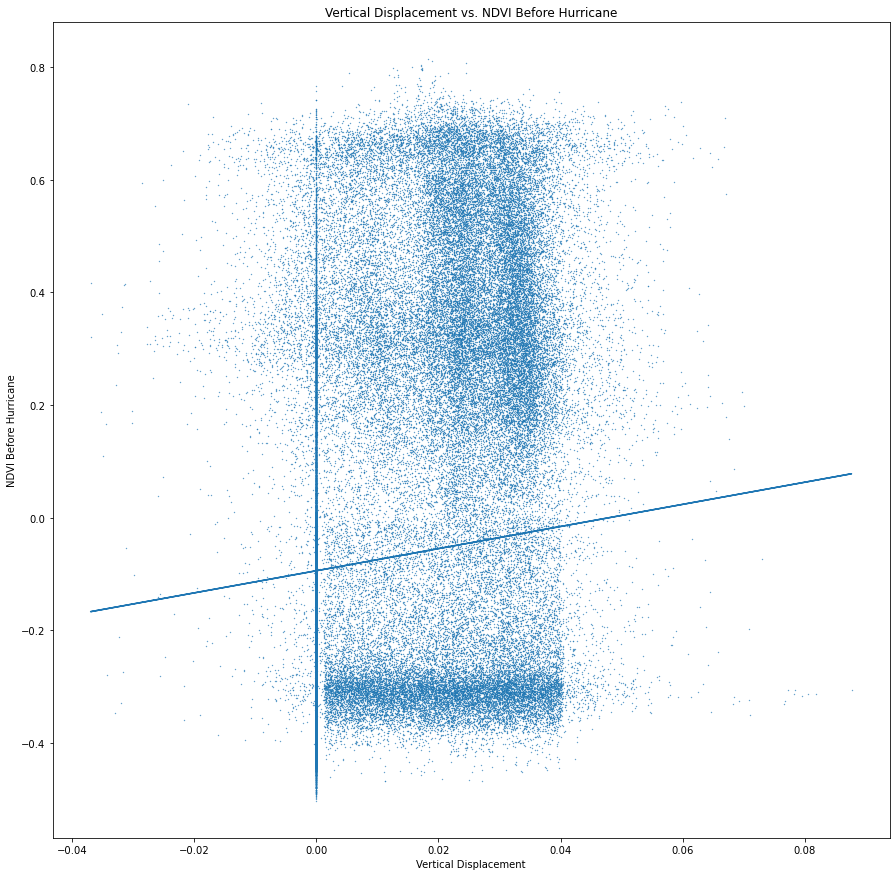

In [31]:
fig = plt.figure(figsize=(15,15))
plt.plot(df["Vertical Displacement"], np.multiply(slope,df["Vertical Displacement"])+intercept)
plt.scatter(df["Vertical Displacement"],df["NDVI Before"], s=0.1)
plt.title("Vertical Displacement vs. NDVI Before Hurricane")
plt.xlabel("Vertical Displacement")
plt.ylabel("NDVI Before Hurricane")

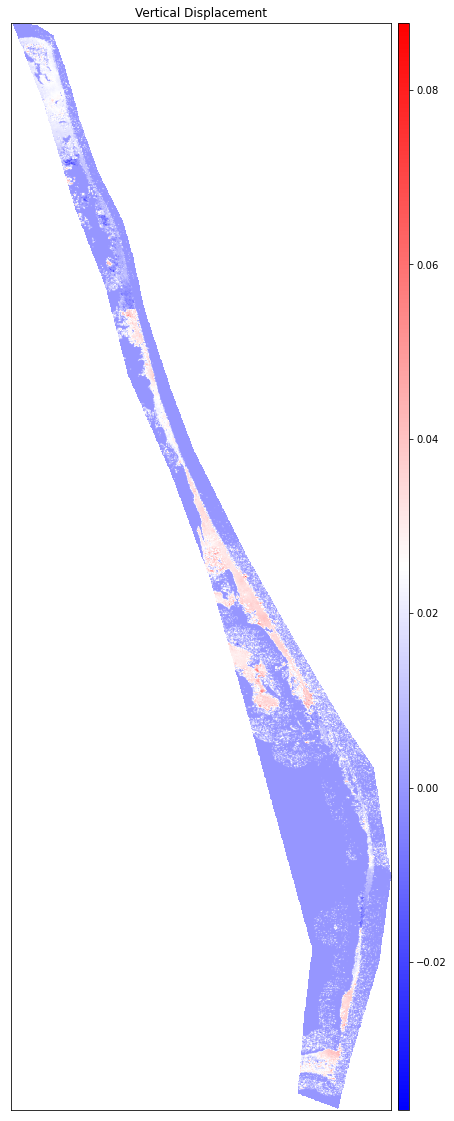

<AxesSubplot:title={'center':'Vertical Displacement'}>

In [32]:
ep.plot_bands(clipped, 
         title="Vertical Displacement",    
         cmap="bwr",
         figsize = (10,20)
        )